In [2]:
import os
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import eval_utils

## Model Evaluation

In [ ]:
HOME = "../../LLM-Deliberation"
OUTPUT_DIR = os.path.join(HOME, "games_descriptions/base_qwen_32b/output/table_3_qwen")
AGENTS_NUM = 6
ISSUES_NUM = 5
NUM_ROUNDS = 24

In [ ]:
agents, role_to_agents, incentive_to_agents = eval_utils.load_setup(
    OUTPUT_DIR, AGENTS_NUM, ISSUES_NUM
)
answers_files = [
    os.path.join(OUTPUT_DIR, filename)
    for filename in os.listdir(OUTPUT_DIR)
    if filename.startswith("history")
]

In [ ]:
"""
Loop over all sessions and aggregate metrics 
"""

prompts = []
wrong_suggested, deal_done, all_agreement, deal_final_round, deal_values_per_agents = (
    [],
    [],
    [],
    [],
    [],
)
gini_values = []
for file_ in answers_files:
    answers = json.load(open(file_))
    metrics = eval_utils.get_metrics(
        agents,
        answers,
        [role_to_agents["p1"], role_to_agents["p2"]],
        NUM_ROUNDS,
        ISSUES_NUM,
        AGENTS_NUM,
    )

    if metrics:
        wrong_suggested.append(metrics[0])
        deal_done.append(metrics[1])
        all_agreement.append(metrics[2])
        deal_final_round.append(metrics[3])
        deal_values_per_agents.append(metrics[4])
        final_deal_values = metrics[4]["SportCo"][-1][-1]
        gini = eval_utils.gini_coefficient(final_deal_values)
        gini_values.append(gini)

print(
    "Percentage of achieved deals at the last round (5-way): "
    + str(sum(deal_final_round) / len(deal_final_round))
)
print(
    "Percentage of achieved deals with all agreement at the last round (6-way): "
    + str(sum(all_agreement) / len(all_agreement))
)
print(
    "Percentage of achieved deals at any round (Any): "
    + str(sum(deal_done) / len(deal_done))
)
print("Percentage of deals violating rules: " + str(np.mean(wrong_suggested)))
print("Avg Gini coefficient for the final deals: " + str(np.mean(gini_values)))

Final deal: A2, B3, C3, D2, E3
Final deal: A2, B3, C3, D2, E4
Final deal: A2, B3, C2, D1, E2
Final deal: A2, B2, C2, D3, E2
Final deal: A2, B2, C2, D2, E4
Final deal: A2, B3, C2, D3, E2
Final deal: A2, B3, C3, D2, E3
Final deal: A2, B3, C2, D1, E2
Final deal: A2, B2, C3, D2, E3
Final deal: A2, B2, C2, D2, E3
Percentage of achieved deals at the last round (5-way): 0.6
Percentage of achieved deals with all agreement at the last round (6-way): 0.3
Percentage of achieved deals at any round (Any): 0.9
Percentage of deals violating rules: 0.08907692307692308
Avg Gini coefficient for the final deals: 0.11583886324808483


In [ ]:
leakage = 0
for filename in answers_files:
    mismatches = eval_utils.check_answers_in_file(filename)
    if mismatches:
        filtered_mismatches = [
            mismatch for mismatch in mismatches if mismatch["round"] != 1
        ]
        if filtered_mismatches:
            print(f"Leakage found in {filename}:")

            for mismatch in filtered_mismatches:
                print(f"  Round {mismatch['round']} (Agent: {mismatch['agent']}):")
                leakage += 1
                # print(f"    Full Answer: {mismatch['full_answer']}")
                # print(f"    Public Answer: {mismatch['public_answer']}")
        else:
            print(f"No mismatches found in {filename} excluding round 1.")
    else:
        print(f"No leakage found in {filename}.")

print("total leakage: ", leakage)

File: ../../LLM-Deliberation/games_descriptions/base_qwen_32b/output/table_3_qwen/history16_16_17.json
No mismatches found in ../../LLM-Deliberation/games_descriptions/base_qwen_32b/output/table_3_qwen/history16_16_17.json excluding round 1.
File: ../../LLM-Deliberation/games_descriptions/base_qwen_32b/output/table_3_qwen/history15_17_52.json
No mismatches found in ../../LLM-Deliberation/games_descriptions/base_qwen_32b/output/table_3_qwen/history15_17_52.json excluding round 1.
File: ../../LLM-Deliberation/games_descriptions/base_qwen_32b/output/table_3_qwen/history17_05_08.json
No mismatches found in ../../LLM-Deliberation/games_descriptions/base_qwen_32b/output/table_3_qwen/history17_05_08.json excluding round 1.
File: ../../LLM-Deliberation/games_descriptions/base_qwen_32b/output/table_3_qwen/history17_21_58.json
No mismatches found in ../../LLM-Deliberation/games_descriptions/base_qwen_32b/output/table_3_qwen/history17_21_58.json excluding round 1.
File: ../../LLM-Deliberation/gam

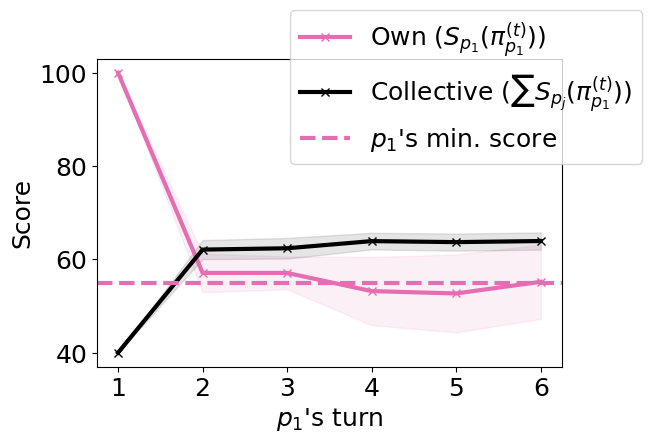

In [ ]:
agent_name = "SportCo"

# reshape metrics as lists across all sessions (i.e., experiments)
# E.g., suggested['own_value'] is the agent's (agent_name) own_score as a list (across sessions) of lists (across rounds)
# 1,0 is session 1 and first round , etc

# 'agree' is the number of agreeing parties for each deal at session i, round j

# 'others scores' is a list of other agents' scores for that deal at session i, round j

# all these metrics are from the persepctive of "agent_name"

suggested = {"own_value": [], "agree": [], "others_scores": [], "avg_value": []}
for session_i, session in enumerate(deal_values_per_agents):
    session_own = []
    session_agree = []
    session_others_scores = []
    session_avg_scores = []

    for i, round_ in enumerate(session[agent_name]):
        session_own.append(round_[0])
        session_agree.append(round_[1])
        session_others_scores.append(round_[-1])
        session_avg_scores.append(np.mean(round_[-1]))

    suggested["own_value"].append(session_own)
    suggested["agree"].append(session_agree)
    suggested["others_scores"].append(session_others_scores)
    suggested["avg_value"].append(session_avg_scores)


# Compute average of metrics of the same round (e.g., round 0), across all negotiation sessions

## own score
average_round_own = []
std_round_own = []

for j in range(0, int(NUM_ROUNDS / AGENTS_NUM) + 2):
    average_round_own.append(
        np.mean(
            [suggested["own_value"][i][j] for i in range(len(suggested["own_value"]))]
        )
    )
    std_round_own.append(
        np.std(
            [suggested["own_value"][i][j] for i in range(len(suggested["own_value"]))]
        )
    )


## collective score
average_collective_deals = []
std_collective_deals = []

for j in range(0, int(NUM_ROUNDS / AGENTS_NUM) + 2):
    average_collective_deals.append(
        np.mean(
            [suggested["avg_value"][i][j] for i in range(len(suggested["avg_value"]))]
        )
    )
    std_collective_deals.append(
        np.std(
            [suggested["avg_value"][i][j] for i in range(len(suggested["avg_value"]))]
        )
    )

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

plt.rcParams["lines.linewidth"] = 3
plt.rc("font", size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(
    x,
    average_round_own,
    marker="x",
    label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)",
    color="#E56DB1",
)
plt.fill_between(
    x,
    np.array(average_round_own) - np.array(std_round_own),
    np.array(average_round_own) + np.array(std_round_own),
    alpha=0.1,
    color="#E56DB1",
)

ax1.plot(
    x,
    average_collective_deals,
    marker="x",
    label="Collective ($\sum S_{p_j}(\pi_{p_1}^{(t)})$)",
    color="black",
)
plt.fill_between(
    x,
    np.array(average_collective_deals) - np.array(std_collective_deals),
    np.array(average_collective_deals) + np.array(std_collective_deals),
    alpha=0.1,
    color="black",
)

ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel("Score")
ax1.axhline(y=55, label="$p_1$'s min. score", color="#E56DB1", linestyle="--")
ax1.legend(loc="best", fontsize=18, bbox_to_anchor=(1.2, 1.2))

plt.show()

## Size vs Performance

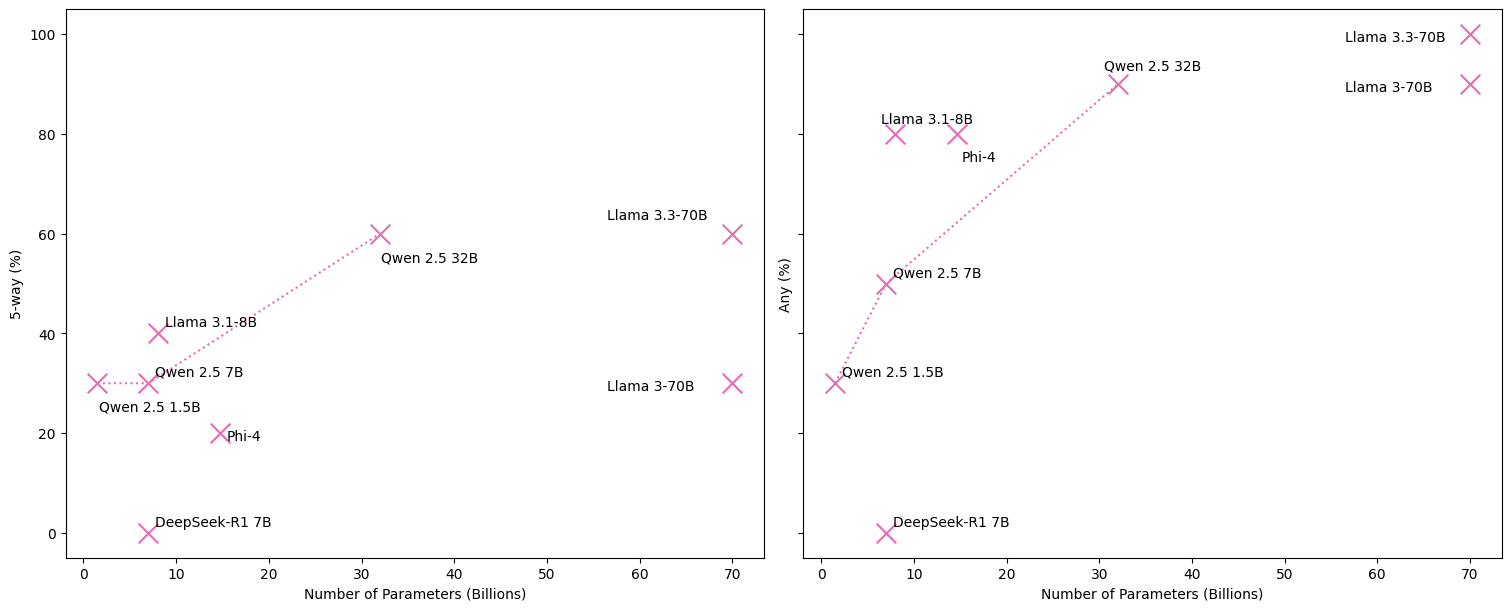

In [13]:
df = pd.DataFrame(
    [
        {"model": "Llama 3.3-70B", "5-way": 60, "6-way": 10, "Any": 100, "size": 70},
        {"model": "Llama 3-70B", "5-way": 30, "6-way": 10, "Any": 90, "size": 70},
        {"model": "Llama 2-13B", "5-way": None, "6-way": None, "Any": None, "size": 13},
        {"model": "Phi-4", "5-way": 20, "6-way": 0, "Any": 80, "size": 14.7},
        {"model": "Llama 3.1-8B", "5-way": 40, "6-way": 10, "Any": 80, "size": 8},
        {"model": "Qwen 2.5 7B", "5-way": 30, "6-way": 0, "Any": 50, "size": 7},
        {"model": "Qwen 2.5 1.5B", "5-way": 30, "6-way": 30, "Any": 30, "size": 1.5},
        {"model": "Qwen 2.5 32B", "5-way": 60, "6-way": 30, "Any": 90, "size": 32},
        {"model": "DeepSeek-R1 7B", "5-way": 0, "6-way": 0, "Any": 0, "size": 7},
    ]
)

fig, axs = plt.subplots(figsize=(15, 6), ncols=2, sharey=True, constrained_layout=True)
quadrants = {
    "top-right": (5, 5),
    "top-left": (-5, 5),
    "bottom-left": (-5, -5),
    "bottom-right": (5, -5),
}

label_positions = {
    "5-way": {
        "GPT-4o Mini": quadrants["top-right"],
        "Llama 3.3-70B": (-90, 10),
        "Llama 3-70B": (-90, -5),
        "Llama 2-13B": quadrants["top-left"],
        "Phi-4": (5, -5),
        "Llama 3.1-8B": quadrants["top-right"],
        "Qwen 2.5 7B": quadrants["top-right"],
        "Qwen 2.5 1.5B": (1, -20),
        "Qwen 2.5 32B": (1, -20),
        "DeepSeek-R1 7B": quadrants["top-right"],
    },
    "6-way": {
        "GPT-4o Mini": (2, -18),
        "Llama 3.3-70B": quadrants["top-left"],
        "Llama 3-70B": quadrants["top-left"],
        "Llama 2-13B": quadrants["top-left"],
        "Phi-4": quadrants["top-right"],
        "Llama 3.1-8B": quadrants["top-left"],
        "Qwen 2.5 7B": (-100, 0),
        "Qwen 2.5 1.5B": quadrants["top-left"],
    },
    "Any": {
        "GPT-4o Mini": (5, 3),
        "Llama 3.3-70B": (-90, -5),
        "Llama 3-70B": (-90, -5),
        "Llama 2-13B": quadrants["top-right"],
        "Phi-4": (3, -20),
        "Llama 3.1-8B": (-10, 8),
        "Qwen 2.5 7B": quadrants["top-right"],
        "Qwen 2.5 1.5B": quadrants["top-right"],
        "Qwen 2.5 32B": (-10, 10),
        "DeepSeek-R1 7B": quadrants["top-right"],
    },
}


for metric, ax in zip(["5-way", "Any"], axs):
    ax.scatter(df["size"], df[metric], color="#E56DB1", marker="x", s=200)

    # Add text labels for each point
    for i, name in enumerate(df["model"]):
        ax.annotate(
            name,
            (df["size"].iloc[i], df[metric].iloc[i]),
            xytext=label_positions[metric][name],  # 5 pixel offset from point
            textcoords="offset points",
        )

    # Add connection between Qwen models
    qwen_df = df[df["model"].str.contains("Qwen")]
    qwen_df = qwen_df.sort_values(by="size")
    ax.plot(qwen_df["size"], qwen_df[metric], color="#E56DB1", linestyle="dotted")

    # Add labels and title
    ax.set_xlabel("Number of Parameters (Billions)")
    ax.set_ylabel(f"{metric} (%)")
    # ax.set_title(f"{metric} Score")
    # ax.set_aspect("equal")

fig.savefig("size_vs_score")

## Single vs Multi Agent

In [ ]:
HOME = "../../LLM-Deliberation"

MULTI_OUTPUT_DIR = os.path.join(
    HOME, "games_descriptions/base_qwen_32b/output/table_3_qwen"
)
SINGLE_OUTPUT_DIR = os.path.join(
    HOME, "games_descriptions/base_qwen_32b/output/table_3_qwen_single_6/row5"
)

AGENTS_NUM = 6
ISSUES_NUM = 5

SINGLE_NUM_ROUNDS = 5
MULTI_NUM_ROUNDS = 24

agent_name = "SportCo"

In [ ]:
(
    single_average_round_own,
    single_std_round_own,
    single_average_collective_deals,
    single_std_collective_deals,
) = eval_utils.get_curves(
    SINGLE_OUTPUT_DIR, AGENTS_NUM, ISSUES_NUM, SINGLE_NUM_ROUNDS, agent_name, "single"
)
(
    multi_average_round_own,
    multi_std_round_own,
    multi_average_collective_deals,
    multi_std_collective_deals,
) = eval_utils.get_curves(
    MULTI_OUTPUT_DIR, AGENTS_NUM, ISSUES_NUM, MULTI_NUM_ROUNDS, agent_name, "multi"
)

Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B2, C2, D2, E3
Final deal: A2, B3, C3, D2, E3
Final deal: A2, B3, C3, D2, E4
Final deal: A2, B3, C2, D1, E2
Final deal: A2, B2, C2, D3, E2
Final deal: A2, B2, C2, D2, E4
Final deal: A2, B3, C2, D3, E2
Final deal: A2, B3, C3, D2, E3
Final deal: A2, B3, C2, D1, E2
Final deal: A2, B2, C3, D2, E3
Final deal: A2, B2, C2, D2, E3


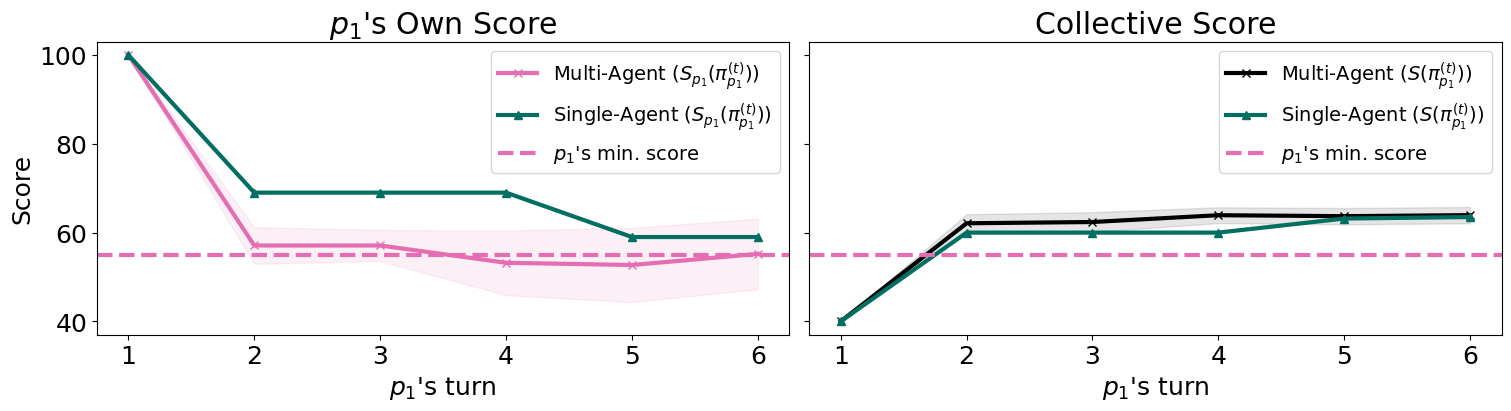

In [ ]:
x_multi = range(1, len(multi_average_round_own) + 1)
x_single = range(1, len(single_average_round_own) + 1)

fig, axs = plt.subplots(figsize=(15, 4), ncols=2, sharey=True, constrained_layout=True)

# Own Score
axs[0].plot(
    x_multi,
    multi_average_round_own,
    marker="x",
    label="Multi-Agent ($S_{p_1}(\pi_{p_1}^{(t)})$)",
    color="#E56DB1",
)
axs[0].fill_between(
    x_multi,
    np.array(multi_average_round_own) - np.array(multi_std_round_own),
    np.array(multi_average_round_own) + np.array(multi_std_round_own),
    alpha=0.1,
    color="#E56DB1",
)

axs[0].plot(
    x_single,
    single_average_round_own,
    marker="^",
    label="Single-Agent ($S_{p_1}(\pi_{p_1}^{(t)})$)",
    color="#006e60",
)
axs[0].fill_between(
    x_single,
    np.array(single_average_round_own) - np.array(single_std_round_own),
    np.array(single_average_round_own) + np.array(single_std_round_own),
    alpha=0.1,
    color="#006e60",
)
axs[0].axhline(y=55, label="$p_1$'s min. score", color="#E56DB1", linestyle="--")
axs[0].set_xlabel("$p_1$'s turn")
axs[0].set_ylabel("Score")
axs[0].set_title("$p_1$'s Own Score")
axs[0].legend(fontsize=14)

# Collective Score
axs[1].plot(
    x_multi,
    multi_average_collective_deals,
    marker="x",
    label="Multi-Agent ($S(\pi_{p_1}^{(t)})$)",
    color="black",
)
axs[1].fill_between(
    x_multi,
    np.array(multi_average_collective_deals) - np.array(multi_std_collective_deals),
    np.array(multi_average_collective_deals) + np.array(multi_std_collective_deals),
    alpha=0.1,
    color="black",
)

axs[1].plot(
    x_single,
    single_average_collective_deals,
    marker="^",
    label="Single-Agent ($S(\pi_{p_1}^{(t)})$)",
    color="#006e60",
)
axs[1].fill_between(
    x_single,
    np.array(single_average_collective_deals) - np.array(single_std_collective_deals),
    np.array(single_average_collective_deals) + np.array(single_std_collective_deals),
    alpha=0.1,
    color="#006e60",
)
axs[1].axhline(y=55, label="$p_1$'s min. score", color="#E56DB1", linestyle="--")
axs[1].set_xlabel("$p_1$'s turn")
axs[1].set_xlabel("$p_1$'s turn")
axs[1].set_title("Collective Score")

axs[1].legend(fontsize=14)
fig.savefig("negotiation_curves_single_multi_qwen32")